In [1]:
# Cell 1: imports and utils
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.dpi'] = 120
sns.set(style="whitegrid")


In [10]:
# Cell 2: paths and load
import os
import pandas as pd
data_dir = "data/data"

# Dictionary of files
files = {
    "Benin-malanville": os.path.join(data_dir, "C:/Users/natna/Downloads/solar discovery challenge/solar-data-discovery-week-0-challenge-/data/benin-malanville.csv"),
    "SierraLeone-bumbuna": os.path.join(data_dir, "C:/Users/natna/Downloads/solar discovery challenge/solar-data-discovery-week-0-challenge-/data/sierraleone-bumbuna.csv"),
    "Togo-dapaong_qc": os.path.join(data_dir, "C:/Users/natna/Downloads/solar discovery challenge/solar-data-discovery-week-0-challenge-/data/togo-dapaong_qc.csv"),
}

# Load data safely
dfs = {}
missing = []

for country, path in files.items():
    if os.path.exists(path):
        dfs[country] = pd.read_csv(path, parse_dates=["Timestamp"], infer_datetime_format=True)
        dfs[country].columns = [c.strip() for c in dfs[country].columns]  # clean column names
    else:
        missing.append(path)

if missing:
    print("WARNING: these cleaned CSVs are missing:", missing)
else:
    print("Loaded:", list(dfs.keys()))


C:\Users\natna\AppData\Local\Temp\ipykernel_11468\3591035759.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[country] = pd.read_csv(path, parse_dates=["Timestamp"], infer_datetime_format=True)
C:\Users\natna\AppData\Local\Temp\ipykernel_11468\3591035759.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[country] = pd.read_csv(path, parse_dates=["Timestamp"], infer_datetime_format=True)
C:\Users\natna\AppData\Local\Temp\ipykernel_11468\3591035759.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed 

Loaded: ['Benin-malanville', 'SierraLeone-bumbuna', 'Togo-dapaong_qc']


In [11]:
# Cell 3: sanity check & keep relevant columns
cols_needed = ["Timestamp","GHI","DNI","DHI","Tamb","RH","ModA","ModB"]
for k, df in dfs.items():
    # keep what exists
    present = [c for c in cols_needed if c in df.columns]
    print(f"{k}: rows={len(df):,}, cols_present={present}")
    # convert numeric columns
    for c in ["GHI","DNI","DHI"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')


Benin-malanville: rows=525,600, cols_present=['Timestamp', 'GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'ModA', 'ModB']
SierraLeone-bumbuna: rows=525,600, cols_present=['Timestamp', 'GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'ModA', 'ModB']
Togo-dapaong_qc: rows=525,600, cols_present=['Timestamp', 'GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'ModA', 'ModB']


In [13]:
# Cell 4: summary table for GHI, DNI, DHI
metrics = ["GHI","DNI","DHI"]
summary_rows = []
for country, df in dfs.items():
    row = {"country": country}
    for m in metrics:
        if m in df.columns:
            row[f"{m}_mean"] = df[m].mean()
            row[f"{m}_median"] = df[m].median()
            row[f"{m}_std"] = df[m].std()
        else:
            row[f"{m}_mean"] = np.nan
            row[f"{m}_median"] = np.nan
            row[f"{m}_std"] = np.nan
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index("country")
summary_df = summary_df[[c for c in summary_df.columns]]  # order preserved
display(summary_df.round(3))
# Save to CSV for report if you want
os.makedirs("outputs", exist_ok=True)
summary_df.to_csv("outputs/summary_table_compare_countries.csv", index=True)


,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
country,,,,,,,,,
Benin-malanville,240.559,1.800,331.131,167.188,-0.100,261.711,115.359,1.600,158.691
SierraLeone-bumbuna,201.958,0.300,298.495,116.376,-0.100,218.653,113.721,-0.100,158.946
Togo-dapaong_qc,230.555,2.100,322.532,151.258,0.000,250.957,116.444,2.500,156.521


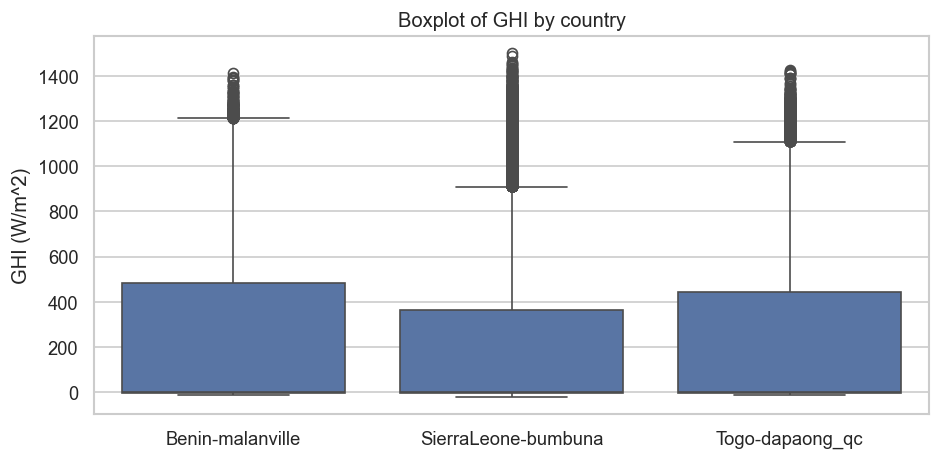

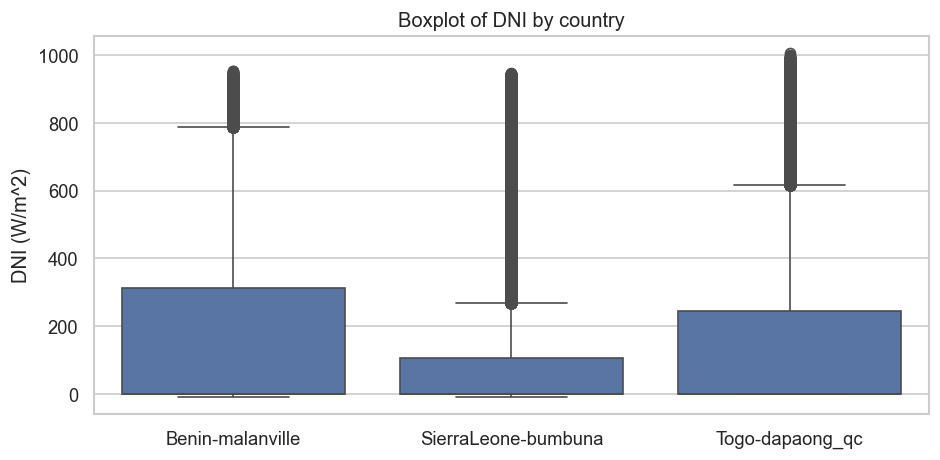

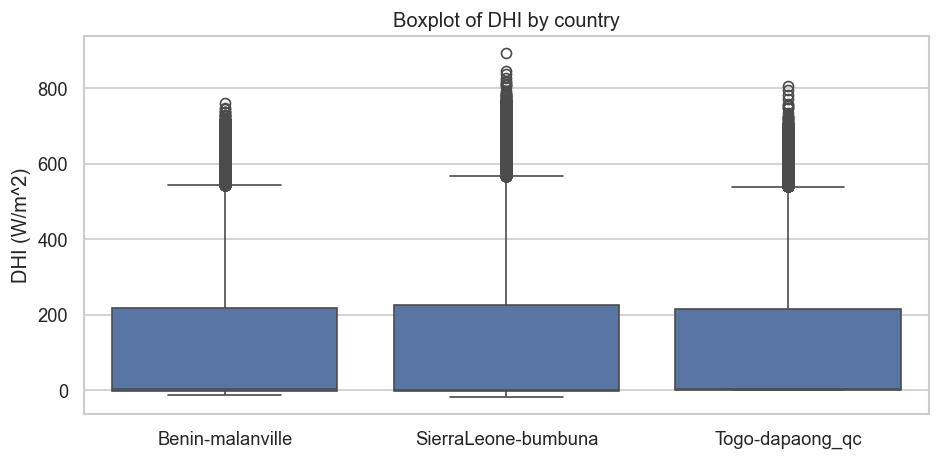

In [14]:
# Cell 5: combined DF for plotting
combined = []
for country, df in dfs.items():
    if "GHI" in df.columns:
        tmp = df[["Timestamp","GHI","DNI","DHI"]].copy()
        tmp["country"] = country
        combined.append(tmp)
combined = pd.concat(combined, ignore_index=True)

# Function to plot a metric
def boxplot_metric(metric):
    plt.figure(figsize=(8,4))
    sns.boxplot(x="country", y=metric, data=combined)
    plt.title(f"Boxplot of {metric} by country")
    plt.ylabel(f"{metric} (W/m^2)")
    plt.xlabel("")
    plt.tight_layout()
    
for m in ["GHI","DNI","DHI"]:
    if m in combined.columns:
        boxplot_metric(m)
        plt.show()


In [15]:
# Cell 6: statistical testing for GHI
# collect GHI per country (dropna)
ghi_groups = [dfs[c]["GHI"].dropna().values for c in dfs.keys() if "GHI" in dfs[c].columns]

# Quick normality check (Shapiro on a sample per group) & Levene for equal variances
print("Group sizes:", {c: len(dfs[c]['GHI'].dropna()) for c in dfs.keys() if 'GHI' in dfs[c].columns})
try:
    lev_stat, lev_p = stats.levene(*ghi_groups)
    print(f"Levene test for equal variances: stat={lev_stat:.3f}, p={lev_p:.3f}")
except Exception as e:
    print("Levene test failed:", e)

# If assumptions roughly satisfied -> one-way ANOVA
f_stat, p_anova = stats.f_oneway(*ghi_groups)
print(f"ANOVA: F={f_stat:.3f}, p={p_anova:.5f}")

# If p_anova is small, difference is significant. If assumptions not met, use Kruskal-Wallis:
kw_stat, p_kw = stats.kruskal(*ghi_groups)
print(f"Kruskal-Wallis: H={kw_stat:.3f}, p={p_kw:.5f}")


Group sizes: {'Benin-malanville': 525600, 'SierraLeone-bumbuna': 525600, 'Togo-dapaong_qc': 525600}
Levene test for equal variances: stat=1877.937, p=0.000
ANOVA: F=2090.093, p=0.00000
Kruskal-Wallis: H=4524.883, p=0.00000


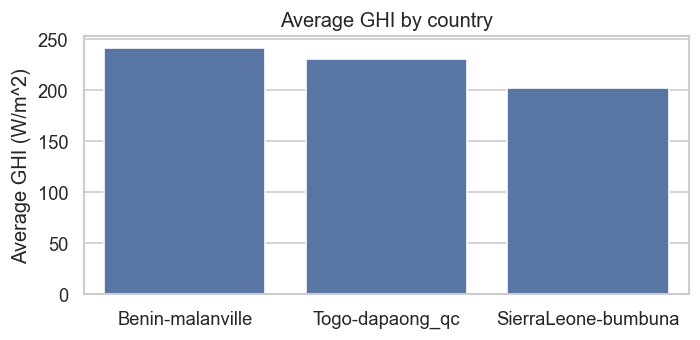

In [16]:
# Cell 7: bar chart ranking by average GHI
avg_ghi = summary_df["GHI_mean"].sort_values(ascending=False)
plt.figure(figsize=(6,3))
sns.barplot(x=avg_ghi.index, y=avg_ghi.values)
plt.title("Average GHI by country")
plt.ylabel("Average GHI (W/m^2)")
plt.xlabel("")
plt.tight_layout()
plt.show()
